In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.neural_network import MLPRegressor


In [2]:
df = pd.read_csv('./data/Train_Final.csv', index_col='Id')
print('Shape of dataset after EDA and Feature Selection : ', df.shape)

Shape of dataset after EDA and Feature Selection :  (1458, 54)


In [3]:
all_cols = df.columns
all_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'MoSold', 'YrSold', 'MSZoning', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType',
       'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [4]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes(include='object')

print('Shape of the dataset with numerical columns : ', df_num.shape)
print('Shape of the dataset with categorical columns : ', df_cat.shape)

Shape of the dataset with numerical columns :  (1458, 28)
Shape of the dataset with categorical columns :  (1458, 26)


In [5]:
num_cols = df_num.columns
num_cols

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'MoSold', 'YrSold'],
      dtype='object')

In [6]:
discrete_num_cols = ['MSSubClass','OverallQual', 'OverallCond',
                     'YearBuilt', 'YearRemodAdd',  'BsmtFullBath',
                     'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                     'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold']
cont_num_cols = list(set(num_cols) - set(discrete_num_cols))
print('Number of discrete numerical columns : ', len(discrete_num_cols))
print('Number of continuous numerical columns : ', len(cont_num_cols))

Number of discrete numerical columns :  15
Number of continuous numerical columns :  13


In [7]:
cat_cols = df_cat.columns
cat_cols

Index(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
       'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [8]:
discrete_cols = list(discrete_num_cols) + list(cat_cols)
print('Number of discrete cols : ', len(discrete_cols))
print(discrete_cols)

Number of discrete cols :  41
['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'SaleType', 'SaleCondition']


In [9]:
null_num_cols = [col for col in df_num.columns if df_num[col].isnull().any()]
print('Numerical columns with null values : ', null_num_cols)

Numerical columns with null values :  ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [10]:
null_cat_cols = [col for col in df_cat.columns if df_cat[col].isnull().any()]
print('Categorical columns with null values : ',null_cat_cols)

Categorical columns with null values :  ['MasVnrType', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish']


In [11]:
impute_transformer = ColumnTransformer(transformers=[
    ('impute_median', SimpleImputer(strategy='median'), cont_num_cols),
    ('mode_impute', SimpleImputer(strategy='most_frequent'), discrete_cols)
], remainder='drop')

In [12]:
encoder_transformer = ColumnTransformer(transformers=[
    ('label_enc', OrdinalEncoder(), cat_cols)
], remainder='drop')

In [15]:
log_num_cols = ['LotArea', 'GarageArea', 'EnclosedPorch',
                'LotFrontage', 'MasVnrArea', 'WoodDeckSF', 'OpenPorchSF']
ss_num_cols = list(set(cont_num_cols) - set(log_num_cols))

scale_transformer = ColumnTransformer(transformers=[
    ('log', FunctionTransformer(np.log1p, validate=False), log_num_cols),
    ('ss', StandardScaler(), ss_num_cols)
], remainder='drop')


In [16]:
Columns_list = {'Numerical_Columns' : num_cols, 
                'Cateogical_Columns' : cat_cols, 
                'Continuous_Numerical_Columns' : cont_num_cols, 
                'Discrete_Numerical_Columns' : discrete_num_cols, 
                'Discrete_Columns' : discrete_cols, 
                'Log_Transform_Columns' : log_num_cols, 
                'StandardScaler_Transform_Columns' : ss_num_cols
                }

pkl.dump(Columns_list, open('./data/Columns_List.pkl', 'wb'))

In [19]:
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,...,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,150,...,No,GLQ,Unf,Ex,Gd,NaN,Attchd,RFn,WD,Normal
2,20,80.0,9600,6,8,1976,1976,0.0,978,284,...,Gd,ALQ,Unf,Ex,TA,TA,Attchd,RFn,WD,Normal
3,60,68.0,11250,7,5,2001,2002,162.0,486,434,...,Mn,GLQ,Unf,Ex,Gd,TA,Attchd,RFn,WD,Normal
4,70,60.0,9550,7,5,1915,1970,0.0,216,540,...,No,ALQ,Unf,Gd,Gd,Gd,Detchd,Unf,WD,Abnorml
5,60,84.0,14260,8,5,2000,2000,350.0,655,490,...,Av,GLQ,Unf,Ex,Gd,TA,Attchd,RFn,WD,Normal


In [21]:
impute_transformer = ColumnTransformer(transformers=[
    ('impute_median', SimpleImputer(strategy='median'), cont_num_cols),
    ('mode_impute', SimpleImputer(strategy='most_frequent'), discrete_cols)
], remainder='drop')

all_cols = list(cont_num_cols) + list(discrete_cols)

df_impute = impute_transformer.fit_transform(df)
df_impute = pd.DataFrame(df_impute, columns=all_cols, index=df.index)
df_impute.head()

,LotFrontage,LotArea,WoodDeckSF,EnclosedPorch,BsmtFinSF1,1stFlrSF,2ndFlrSF,GrLivArea,BsmtUnfSF,OpenPorchSF,...,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450.0,0.0,0.0,706.0,856.0,854.0,1710.0,150.0,61.0,...,No,GLQ,Unf,Ex,Gd,Gd,Attchd,RFn,WD,Normal
2,80.0,9600.0,298.0,0.0,978.0,1262.0,0.0,1262.0,284.0,0.0,...,Gd,ALQ,Unf,Ex,TA,TA,Attchd,RFn,WD,Normal
3,68.0,11250.0,0.0,0.0,486.0,920.0,866.0,1786.0,434.0,42.0,...,Mn,GLQ,Unf,Ex,Gd,TA,Attchd,RFn,WD,Normal
4,60.0,9550.0,0.0,272.0,216.0,961.0,756.0,1717.0,540.0,35.0,...,No,ALQ,Unf,Gd,Gd,Gd,Detchd,Unf,WD,Abnorml
5,84.0,14260.0,192.0,0.0,655.0,1145.0,1053.0,2198.0,490.0,84.0,...,Av,GLQ,Unf,Ex,Gd,TA,Attchd,RFn,WD,Normal


In [22]:
encoder_transformer = ColumnTransformer(transformers=[
                        ('label_enc', OrdinalEncoder(), cat_cols)
                        ], remainder='drop')

df_encode = encoder_transformer.fit_transform(df_impute)
df_encode = pd.DataFrame(df_encode, columns=cat_cols, index=df.index)
df_encode.head()

,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,...,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,3.0,3.0,3.0,4.0,5.0,2.0,0.0,5.0,1.0,12.0,...,3.0,2.0,5.0,0.0,2.0,2.0,1.0,1.0,8.0,4.0
2,3.0,3.0,3.0,2.0,24.0,1.0,0.0,2.0,1.0,8.0,...,1.0,0.0,5.0,0.0,3.0,4.0,1.0,1.0,8.0,4.0
3,3.0,0.0,3.0,4.0,5.0,2.0,0.0,5.0,1.0,12.0,...,2.0,2.0,5.0,0.0,2.0,4.0,1.0,1.0,8.0,4.0
4,3.0,0.0,3.0,0.0,6.0,2.0,0.0,5.0,1.0,13.0,...,3.0,0.0,5.0,2.0,2.0,2.0,5.0,2.0,8.0,0.0
5,3.0,0.0,3.0,2.0,15.0,2.0,0.0,5.0,1.0,12.0,...,0.0,2.0,5.0,0.0,2.0,4.0,1.0,1.0,8.0,4.0


In [24]:
log_num_cols


['LotArea',
 'GarageArea',
 'EnclosedPorch',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF',
 'OpenPorchSF']

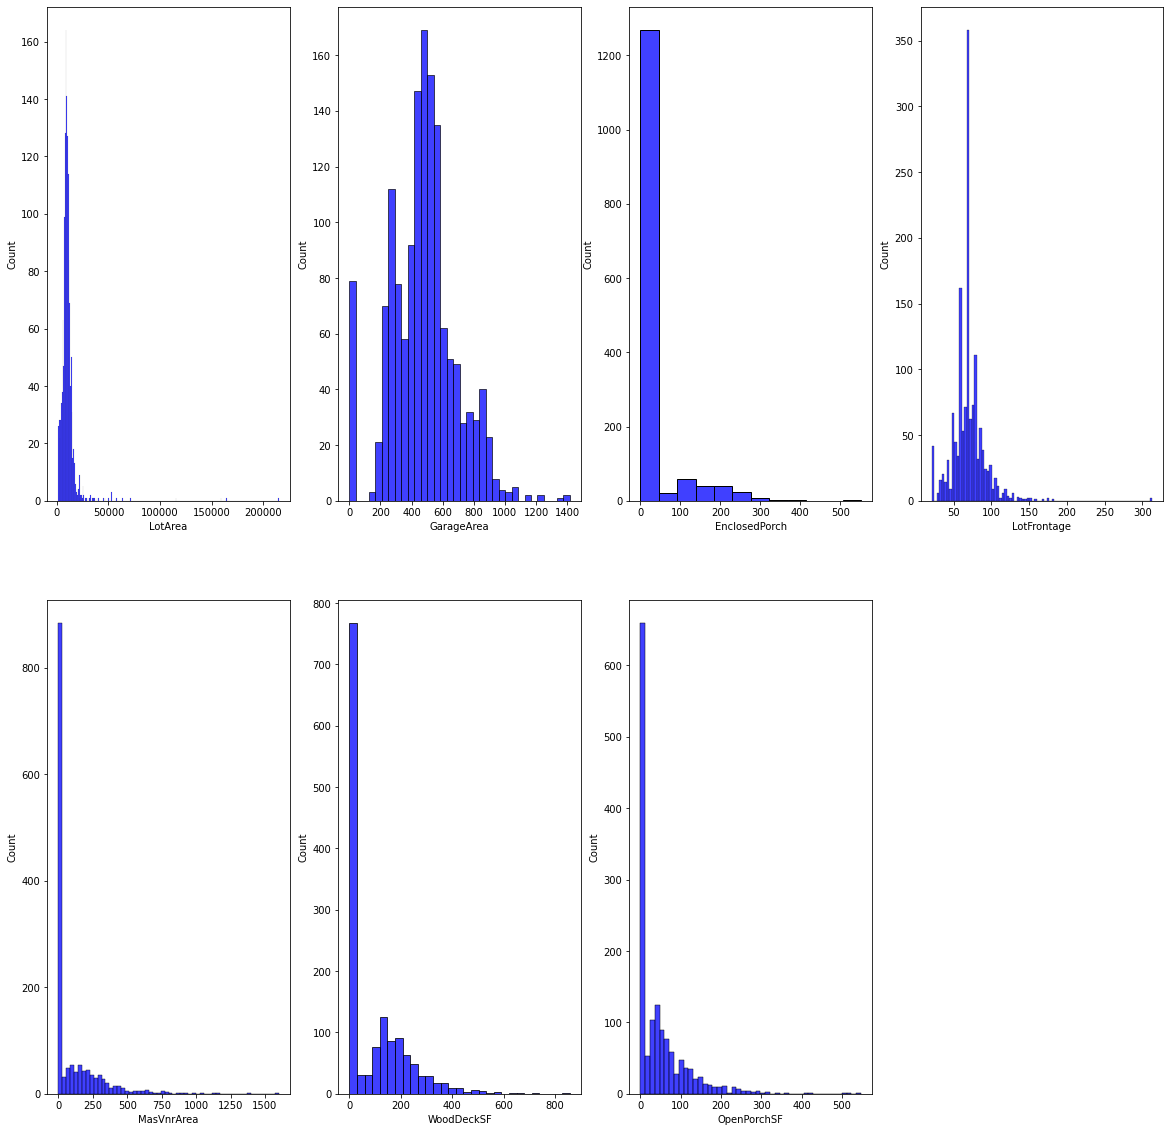

In [25]:
plt.figure(figsize=(20,20))
for index, col in enumerate(log_num_cols):    
    plt.subplot(2,4, index + 1)
    sns.histplot(x = col, data = df_impute, color = 'blue')

In [42]:
scale_transformer = ColumnTransformer(transformers=[
    ('log', FunctionTransformer(np.log1p, validate=False), log_num_cols),
    ('ss', StandardScaler(), ss_num_cols)
], remainder='drop')

cont_num_cols = list(log_num_cols) + list(ss_num_cols)
df_impute[cont_num_cols] = df_impute[cont_num_cols].astype('float32')

df_scale = scale_transformer.fit_transform(df_impute)
df_scale = pd.DataFrame(df_scale, columns=cont_num_cols, index=df.index)
df_scale.head()


,LotArea,GarageArea,EnclosedPorch,LotFrontage,MasVnrArea,WoodDeckSF,OpenPorchSF,BsmtFinSF1,2ndFlrSF,GrLivArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF
Id,,,,,,,,,,,,,
1,9.042040,6.308098,0.000000,4.189655,5.283204,0.000000,4.127134,0.574649,1.164986,0.373550,-0.944072,-0.459210,-0.793119
2,9.169622,6.133398,0.000000,4.394449,0.000000,5.700444,0.000000,1.170851,-0.795330,-0.482874,-0.640685,0.466396,0.257082
3,9.328213,6.411819,0.000000,4.234107,5.093750,0.000000,3.761200,0.092427,1.192532,0.518837,-0.301073,-0.313301,-0.627570
4,9.164401,6.466145,5.609472,4.110874,0.000000,0.000000,3.583519,-0.499391,0.940032,0.386932,-0.061080,-0.687191,-0.521515
5,9.565284,6.729824,0.000000,4.442651,5.860786,5.262690,4.442651,0.462862,1.621782,1.306441,-0.174284,0.199658,-0.045562


In [60]:
df_train = pd.merge(df_scale, df_impute[discrete_num_cols], on='Id')
df_train.head()


,LotArea,GarageArea,EnclosedPorch,LotFrontage,MasVnrArea,WoodDeckSF,OpenPorchSF,BsmtFinSF1,2ndFlrSF,GrLivArea,...,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,9.042040,6.308098,0.000000,4.189655,5.283204,0.000000,4.127134,0.574649,1.164986,0.373550,...,1,2,1,3,8,0,2003.0,2,2,2008
2,9.169622,6.133398,0.000000,4.394449,0.000000,5.700444,0.000000,1.170851,-0.795330,-0.482874,...,0,2,0,3,6,1,1976.0,2,5,2007
3,9.328213,6.411819,0.000000,4.234107,5.093750,0.000000,3.761200,0.092427,1.192532,0.518837,...,1,2,1,3,6,1,2001.0,2,9,2008
4,9.164401,6.466145,5.609472,4.110874,0.000000,0.000000,3.583519,-0.499391,0.940032,0.386932,...,1,1,0,3,7,1,1998.0,3,2,2006
5,9.565284,6.729824,0.000000,4.442651,5.860786,5.262690,4.442651,0.462862,1.621782,1.306441,...,1,2,1,4,9,1,2000.0,3,12,2008


In [61]:
df_train = pd.merge(df_train, df_encode[cat_cols], on='Id')
df_train.head()


,LotArea,GarageArea,EnclosedPorch,LotFrontage,MasVnrArea,WoodDeckSF,OpenPorchSF,BsmtFinSF1,2ndFlrSF,GrLivArea,...,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageType,GarageFinish,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,9.042040,6.308098,0.000000,4.189655,5.283204,0.000000,4.127134,0.574649,1.164986,0.373550,...,3.0,2.0,5.0,0.0,2.0,2.0,1.0,1.0,8.0,4.0
2,9.169622,6.133398,0.000000,4.394449,0.000000,5.700444,0.000000,1.170851,-0.795330,-0.482874,...,1.0,0.0,5.0,0.0,3.0,4.0,1.0,1.0,8.0,4.0
3,9.328213,6.411819,0.000000,4.234107,5.093750,0.000000,3.761200,0.092427,1.192532,0.518837,...,2.0,2.0,5.0,0.0,2.0,4.0,1.0,1.0,8.0,4.0
4,9.164401,6.466145,5.609472,4.110874,0.000000,0.000000,3.583519,-0.499391,0.940032,0.386932,...,3.0,0.0,5.0,2.0,2.0,2.0,5.0,2.0,8.0,0.0
5,9.565284,6.729824,0.000000,4.442651,5.860786,5.262690,4.442651,0.462862,1.621782,1.306441,...,0.0,2.0,5.0,0.0,2.0,4.0,1.0,1.0,8.0,4.0


In [49]:
df_train.shape


(1458, 54)

In [57]:
df_train.to_csv('./data/Train_Final.csv')